In [1]:
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
# import electrode
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped, utils)
from scipy.signal import argrelextrema
import math
from scipy.optimize import minimize



np.set_printoptions(precision=2) # have numpy print fewer digits

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
l = 50e-6 # µm length scale
m = 40*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
o = 80*np.pi*1e6 # rf frequency in rad/s
rf_scale = np.sqrt(q/m)/(2*l*o) # scaling factor for sim

In [3]:
# Segmented RF Trap

In [4]:
def segment_rf_trap(bottom, top, left, right, center_height, rf_height1, rf_height2):
    ch = center_height
    rh1 = rf_height1
    rh2 = rf_height2
    b = bottom
    t = top
    l = left
    r = right
    electrodes = [
        ("ct", [[(-l, t), (-l, rh1 + rh2 + ch/2), (r, rh1 + rh2 + ch/2), (r, t)]]),
        ("tr1", [[(-l, rh1 + ch/2), (-l, ch/2), (r, ch/2), (r, rh1 + ch/2)]]),
        ("br1", [[(-l, -ch/2), (-l, -rh1 - ch/2), (r, -rh1 - ch/2), (r, -ch/2)]]),
        ("cc", [[(-l, ch/2), (-l, -ch/2), (r, -ch/2), (r, ch/2)]]),
        ("tr2", [[(-l, rh1 + rh2 + ch/2), (-l, rh1 + ch/2), (r, rh1 + ch/2), (r, rh1 + rh2 + ch/2)]]),
        ("br2", [[(-l, -rh1 - ch/2), (-l, -rh1 - rh2 - ch/2), (r, -rh1 - rh2 - ch/2), (r, -rh1 - ch/2)]]),
        ("cb", [[(-l, -rh1 - rh2 - ch/2), (-l, -b), (r, -b), (r, -rh1 - rh2 - ch/2)]]),
        ]
    
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])
   
    s["tr1"].rf = 1.
    s["br1"].rf = 1.
    s["tr2"].rf = 1.
    s["br2"].rf = 1.
    return s

In [5]:
def pull_freqs_z(junction, n = 1000, start_z = 0.8, end_z = 1.5, x_search = 0, y_search = 0):
    # extracts potential confinement values
    x = x_search
    y = y_search

    xyz = np.mgrid[x:x+1, y:y+1, start_z:end_z:1j*n]

    pre_pot2 = shaped(junction.potential)(xyz, derivative = 2)
    pre_pot = np.zeros((1, 1, n))
        
    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pre_pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][0][0]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][1][1]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][2][2]
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    pre_z_conf_values = np.reshape(pre_pot, (n))

    pre_z_conf_values /= (l ** 2) # eV / m^2
    pre_z_conf_values *= 1.602e-19 # J / m^2
    trap_freqs = (np.sqrt(pre_z_conf_values / m) / ( 2 * math.pi * 1e6)) # MHz
    # 'summed' frequencies


    z_values = np.reshape(xyz[2], (n))

    return [z_values, trap_freqs]

In [6]:
def pull_potential_values_z(junction, n = 1000, start_z = 0.8, end_z = 1.5, x_search = 0, y_search = 0):
    # pull potential values
    x = x_search
    y = y_search

    xyz = np.mgrid[x:x+1, y:y+1, start_z:end_z:1j*n]
        

    pot2 = shaped(junction.potential)(xyz, derivative = 0)
    pot = np.zeros((1, 1, n))

    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                curr_grad = pot2[i_counter][j_counter][k_counter]
                pot[i_counter][j_counter][k_counter] += curr_grad
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    z_pot_values = np.reshape(pot, (n))

    z_values = np.reshape(xyz[2], (n))

    return [z_values, z_pot_values]

In [7]:
def pull_potential_values_x(junction, n = 1000, start_x = -20, end_x = 20, z_search = 1, y_search = 0):
    # maybe later on, be able to put in array of z values
    # pull potential values
    z = z_search
    y = y_search

    xyz = np.mgrid[start_x:end_x:1j*n, y:y+1, z:z+1]
        

    pot2 = shaped(junction.potential)(xyz, derivative = 0)
    pot = np.zeros((n, 1, 1))

    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                curr_grad = pot2[i_counter][j_counter][k_counter]
                pot[i_counter][j_counter][k_counter] += curr_grad
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    x_pot_values = np.reshape(pot, (n))

    x_values = np.reshape(xyz[0], (n))

    return [x_values, x_pot_values]

In [8]:
def pull_potential_values_y(junction, n = 1000, start_y = -5, end_y = 5, z_search = 1, x_search = 0):
    # maybe later on, be able to put in array of z values
    # pull potential values
    z = z_search
    x = x_search

    xyz = np.mgrid[x:x+1, start_y:end_y:1j*n, z:z+1]
        

    pot2 = shaped(junction.potential)(xyz, derivative = 0)
    pot = np.zeros((1, n, 1))

    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                curr_grad = pot2[i_counter][j_counter][k_counter]
                pot[i_counter][j_counter][k_counter] += curr_grad
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    x_pot_values = np.reshape(pot, (n))

    x_values = np.reshape(xyz[1], (n))

    return [x_values, x_pot_values]

In [9]:
def pull_potential_values_yz(junction, n_y = 50, n_z = 50, start_y = -1, end_y = 1, start_z = 0.3, end_z = 1.7, x_search = 0):
# pull potential values in 2-dimensioonal plane
    x = x_search

    xyz = np.mgrid[x:x+1, start_y:end_y:1j*n_y, start_z:end_z:1j*n_z]
        

    pot2 = shaped(junction.potential)(xyz, derivative = 0)
    pot = np.zeros((1, n_y, n_z))

    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                curr_grad = pot2[i_counter][j_counter][k_counter]
                pot[i_counter][j_counter][k_counter] += curr_grad
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    pot_values = np.reshape(pot, (1, n_y, n_z))

    pos_values = xyz

    return [pos_values, pot_values]
    


In [10]:
def pull_freqs_x(junction, n = 1000, start_x = -20, end_x = 20, z_search = 1, y_search = 0):
    # again, maybe later on, change so we can search array of z
    # extracts potential confinement values
    z = z_search
    y = y_search

    xyz = np.mgrid[start_x:end_x:1j*n, y:y+1, z:z+1]

    pre_pot2 = shaped(junction.potential)(xyz, derivative = 2)
    pre_pot = np.zeros((n, 1, 1))
        
    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pre_pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][0][0]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][1][1]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][2][2]
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    pre_x_conf_values = np.reshape(pre_pot, (n))

    pre_x_conf_values /= (l ** 2) # eV / m^2
    pre_x_conf_values *= 1.602e-19 # J / m^2
    trap_freqs = (np.sqrt(pre_x_conf_values / m) / ( 2 * math.pi * 1e6)) # MHz
    # 'summed' frequencies


    x_values = np.reshape(xyz[0], (n))

    return [x_values, trap_freqs]

In [11]:
def pull_freqs_y(junction, n = 1000, start_y = -5, end_y = 5, z_search = 1, x_search = 0):
    # again, maybe later on, change so we can search array of z
    # extracts potential confinement values
    z = z_search
    x = x_search

    xyz = np.mgrid[x:x+1, start_y:end_y:1j*n, z:z+1]

    pre_pot2 = shaped(junction.potential)(xyz, derivative = 2)
    pre_pot = np.zeros((1, n, 1))
        
    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pre_pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][0][0]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][1][1]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][2][2]
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    pre_x_conf_values = np.reshape(pre_pot, (n))

    pre_x_conf_values /= (l ** 2) # eV / m^2
    pre_x_conf_values *= 1.602e-19 # J / m^2
    trap_freqs = (np.sqrt(pre_x_conf_values / m) / ( 2 * math.pi * 1e6)) # MHz
    # 'summed' frequencies


    x_values = np.reshape(xyz[1], (n))

    return [x_values, trap_freqs]

In [12]:
def pull_freqs_yz(junction, n_y = 50, n_z = 50, start_y = -1, end_y = 1, start_z = 0.3, end_z = 1.7, x_search = 0):
    # extract freqs in yz plane
    x = x_search

    xyz = np.mgrid[x:x+1, start_y:end_y:1j*n_y, start_z:end_z:1j*n_z]

    pre_pot2 = shaped(junction.potential)(xyz, derivative = 2)
    pre_pot = np.zeros((1, n_y, n_z))
        
    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pre_pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][0][0]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][1][1]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][2][2]
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    pre_x_conf_values = pre_pot

    pre_x_conf_values /= (l ** 2) # eV / m^2
    pre_x_conf_values *= 1.602e-19 # J / m^2
    trap_freqs = (np.sqrt(pre_x_conf_values / m) / ( 2 * math.pi * 1e6)) # MHz
    # 'summed' frequencies

    pos_values = xyz


    return [pos_values, trap_freqs]

In [13]:
def pull_potential_values_at_z(junction, z_search, n = 200, start_x = 0, end_x = 20):
# pull potential values at specific place
    xyz = np.zeros((3, n, 1, 1))

    delta_x = (end_x - start_x) / (n - 1.)

    # creation of own mesh grid that goes along branch
    z_search_shape = np.reshape(z_search, (n, 1, 1))
    xyz[2] = z_search_shape
    xyz[0] = np.reshape(np.linspace(start_x, end_x, n), (n, 1, 1))

    pot2 = shaped(junction.potential)(xyz, derivative = 0)
            
    x_pot_values = np.reshape(pot2, (n))

    x_values = np.reshape(xyz[0], (n))

    return [x_values, x_pot_values]

In [14]:
def pull_freqs_at_z(junction, z_search, n = 200, start_x = 0, end_x = 20):
    # pull potential values at specific place
    xyz = np.zeros((3, n, 1, 1))

    # creation of own mesh grid that goes along branch
    z_search_shape = np.reshape(z_search, (n, 1, 1))
    xyz[2] = z_search_shape
    xyz[0] = np.reshape(np.linspace(start_x, end_x, n), (n, 1, 1))

    pre_pot2 = shaped(junction.potential)(xyz, derivative = 2)
    pre_pot = np.zeros((n, 1, 1))
        
    i_counter = 0 
    j_counter = 0
    k_counter = 0


    for i in pre_pot2:
        j_counter = 0
        for j in i:
            k_counter = 0
            for k in j:
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][0][0]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][1][1]
                pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][2][2]
                
                k_counter += 1
            j_counter += 1
        i_counter += 1


            
    pre_x_conf_values = np.reshape(pre_pot, (n))

    pre_x_conf_values /= (l ** 2) # eV / m^2
    pre_x_conf_values *= 1.602e-19 # J / m^2
    trap_freqs = (np.sqrt(pre_x_conf_values / m) / ( 2 * math.pi * 1e6)) # MHz

    x_values = np.reshape(xyz[0], (n))

    return [x_values, trap_freqs]

In [15]:
def pull_ion_transport_path_min_pot(junction, n_x = 200, start_x = 0, end_x = 20):
    # Minimum potential ion transport path

    min_z = np.zeros((n_x))
    x_vals = np.zeros((n_x))
    arr_min_pot = np.zeros((n_x))

    delta_x = (end_x - start_x) / (n_x - 1)

    search_y = 0
    start_z = 0.5 
    end_z = 2

    for i in range(n_x):
        # n = 250
        min_n = 250
        x = start_x + (i * delta_x)
            
        # xyz = np.mgrid[x:x+1, search_y:search_y+1, start_z:end_z:1j*min_n] 
        xyz = np.zeros((3, 1, 1, min_n))
        xyz[0] = np.ones((1, 1, min_n)) * (start_x + (i * delta_x))        
        xyz[2] = np.linspace(start_z, end_z, min_n)

        # print (np.shape(xyz))

        min_pot = shaped(junction.potential)(xyz, derivative = 0)
        p = np.reshape(min_pot, (min_n))
        z = np.reshape(xyz[2], (min_n))

        min_index = np.argmin(p)
        min_z[i] = z[min_index]
        x_vals[i] = x
        arr_min_pot[i] = p[min_index]


    return [x_vals, min_z, arr_min_pot]


In [16]:
def pull_ion_transport_path_const_freq(junction, n_x = 200, start_x = 0, end_x = 10, start_z = 0.7, end_z = 1.1, nn = 300, lower_freq = 28.25, upper_freq = 28.45): # optimized for double RF at z = 1h
    # Constant confinement ion transport path

    const_z = np.zeros((n_x))
    x_vals = np.zeros((n_x))
    const_freq = np.zeros((n_x))

    delta_x = (end_x - start_x) / (n_x - 1)

    for i in range(n_x):

        x = start_x + (i * delta_x)
        xyz = np.zeros((3, 1, 1, nn))
        xyz[0] = np.ones((1, 1, nn)) * x
        xyz[2] = np.reshape(np.linspace(start_z, end_z, nn), (1, 1, nn))
            
        z = np.reshape(xyz[2], (nn))

        pre_pot2 = shaped(junction.potential)(xyz, derivative = 2)
        pre_pot = np.zeros((1, 1, nn))
        
        i_counter = 0 
        j_counter = 0
        k_counter = 0

        curr_const_z = 0
        greater_const_z_bool = True
        lesser_const_z_bool = True
        
        curr_const_freq = 0
        for ii in pre_pot2:
            j_counter = 0
            for j in ii:
                k_counter = 0
                for k in j:
                    pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][0][0]
                    pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][1][1]
                    pre_pot[i_counter][j_counter][k_counter] += pre_pot2[i_counter][j_counter][k_counter][2][2]

                    pre_pot[i_counter][j_counter][k_counter] /= (l ** 2) # eV / m^2
                    pre_pot *= 1.602e-19 # J / m^2
                    trap_freqs = (np.sqrt(pre_pot / m) / ( 2 * math.pi * 1e6)) # MHz

                    lower_threshold_freq = lower_freq # set these appropriately
                    upper_threshold_freq = upper_freq

                    if (trap_freqs[i_counter][j_counter][k_counter] > lower_threshold_freq):
                        if (trap_freqs[i_counter][j_counter][k_counter] < upper_threshold_freq):
                            curr_const_z = z[k_counter]
                            curr_const_freq = trap_freqs[i_counter][j_counter][k_counter]
                            greater_const_z_bool = False 
                            lesser_const_z_bool = False

                    
                    k_counter += 1
                j_counter += 1
            i_counter += 1

            if (greater_const_z_bool):
                print ("not in bound")

            if (lesser_const_z_bool):
                print ("not in bound")

            if (not (greater_const_z_bool or lesser_const_z_bool)):
                print ("in bounds")

        # change such that use index that is equal to limit confinement

        const_z[i] = curr_const_z
        x_vals[i] = x
        const_freq[i] = curr_const_freq

    return [x_vals, const_z, const_freq]



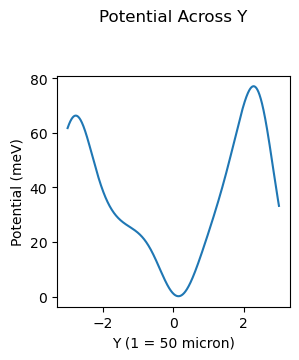

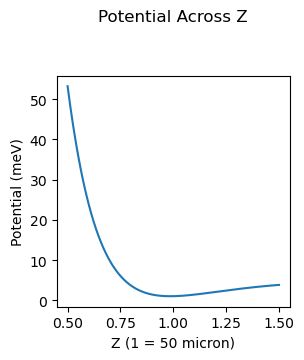

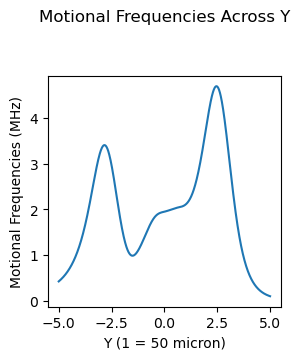

0.14714714714714727


In [17]:
a = 0.83
b = 1.99 
c = 0.5
V1 = 10
V2 = 2*V1
r = 300

ch1 = a 
rh1 = b 
rh2 = c 

# simulation test

l = 50e-6 # µm length scale
m = 40*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
o = 80*np.pi*1e6 # rf frequency in rad/s
rf_scale = np.sqrt(q/m)/(2*l*o) # scaling factor for sim

anal_seg_lin_junc = segment_rf_trap(r, r, r, r, ch1, rh1, rh2)
anal_seg_lin_junc["tr1"].rf = V1*rf_scale
anal_seg_lin_junc["br1"].rf = V1*rf_scale
anal_seg_lin_junc["br2"].rf = V2*rf_scale
anal_seg_lin_junc["tr2"].rf = -V2*rf_scale
y_values, y_pot = pull_potential_values_y(anal_seg_lin_junc, start_y = -3, end_y = 3)
z_values, z_pot = pull_potential_values_z(anal_seg_lin_junc, start_z = 0.5, end_z = 1.5)
y_values2, y_freqs = pull_freqs_y(anal_seg_lin_junc)

plt.figure(figsize = (3,3))
plt.plot(y_values, y_pot * 1e3)
plt.xlabel("Y (1 = 50 micron)")
plt.ylabel("Potential (meV)")
plt.title("Potential Across Y", y= 1.2)
plt.show()

plt.figure(figsize = (3,3))
plt.plot(z_values, z_pot * 1e3)
plt.xlabel("Z (1 = 50 micron)")
plt.ylabel("Potential (meV)")
plt.title("Potential Across Z", y= 1.2)
plt.show()

plt.figure(figsize = (3,3))
plt.plot(y_values2, y_freqs)
plt.xlabel("Y (1 = 50 micron)")
plt.ylabel("Motional Frequencies (MHz)")
plt.title("Motional Frequencies Across Y", y= 1.2)
plt.show()
 
min_y_point = np.unravel_index( np.argmin(y_pot), np.shape(y_pot))
print (y_values[min_y_point])

# fig, ax = plt.subplots(1, 2)
# anal_seg_lin_junc.plot(ax[0])
# anal_seg_lin_junc.plot_voltages(ax[1], u=anal_seg_lin_junc.rfs)

# for axi in ax.flat:
#     axi.set_aspect("equal")
#     axi.set_xlim(-r, r)
#     axi.set_ylim(-r, r)

# plt.setp(ax[0], xlabel = "X (trap heights)")
# plt.setp(ax[0], ylabel = "Y (trap heights)")
# plt.setp(ax[0], title = "Electrode Diagram of Spline Variable RF X Junction")






In [19]:
min_pot_point = np.unravel_index( np.argmin(y_pot), np.shape(y_pot))
min_trap_y = y_values[min_pot_point]
print(min_trap_y)
print(y_pot [min_pot_point])

0.14714714714714727
0.00010330878778619294


In [34]:
n_factors_V2 = 100
factors_V2 = np.linspace(0, 20, n_factors_V2)

a = 0.83
b = 1.99 
c = 0.50
V1 = 10
r = 300

ch1 = a 
rh1 = b 
rh2 = c 

# simulation test

l = 50e-6 # µm length scale
m = 40*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
o = 80*np.pi*1e6 # rf frequency in rad/s
rf_scale = np.sqrt(q/m)/(2*l*o) # scaling factor for sim

horiz_pots = np.zeros(n_factors_V2)
horiz_mins = np.zeros(n_factors_V2)
horiz_curvs = np.zeros(n_factors_V2)
horiz_freqs = np.zeros(n_factors_V2)

counter_curr = 0
for curr_factor_V2 in factors_V2:
    V2 = curr_factor_V2 * V1
    anal_seg_lin_junc = segment_rf_trap(r, r, r, r, ch1, rh1, rh2)
    anal_seg_lin_junc["tr1"].rf = V1*rf_scale
    anal_seg_lin_junc["br1"].rf = V1*rf_scale
    anal_seg_lin_junc["br2"].rf = V2*rf_scale
    anal_seg_lin_junc["tr2"].rf = -V2*rf_scale
    y_values, y_pot = pull_potential_values_y(anal_seg_lin_junc, start_y = -3, end_y = 3)
    y_values2, y_freqs = pull_freqs_y(anal_seg_lin_junc, start_y = -3, end_y = 3)
    y_curvs = y_freqs * 2 * math.pi * 10e6
    y_curvs = np.square(y_curvs) * m 
    y_curvs /= 1.602e-19 # eV / m^2
    y_curvs *= 1e3 # meV / m^2
    y_curvs /= (1e6) ** 2 # meV / micron^2

    min_pot_point = np.unravel_index( np.argmin(y_pot), np.shape(y_pot))
    horiz_mins[counter_curr] = y_values[min_pot_point]
    horiz_pots[counter_curr] = y_pot[min_pot_point]
    horiz_curvs[counter_curr] = y_curvs[min_pot_point]
    horiz_freqs[counter_curr] = y_freqs[min_pot_point]

    counter_curr += 1


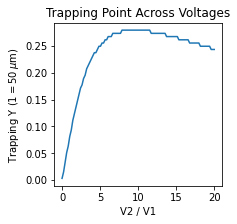

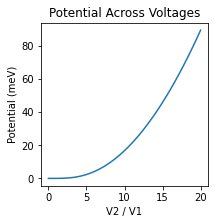

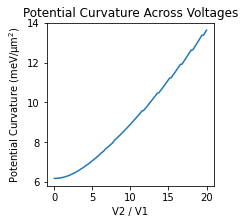

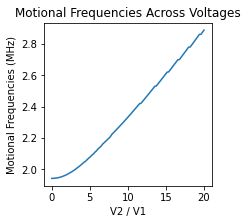

In [35]:
plt.figure(figsize = (3,3))
plt.plot(factors_V2, horiz_mins)
plt.xlabel("V2 / V1")
plt.ylabel("Trapping Y ($1=50\:\mu\mathrm{m}$)")
plt.title("Trapping Point Across Voltages")
plt.show()

plt.figure(figsize = (3,3))
plt.plot(factors_V2, horiz_pots * 1e3)
plt.xlabel("V2 / V1")
plt.ylabel("Potential (meV)")
plt.title("Potential Across Voltages")
plt.show()

plt.figure(figsize = (3,3))
plt.plot(factors_V2, horiz_curvs)
plt.xlabel("V2 / V1")
plt.ylabel("Potential Curvature ($\mathrm{meV/\mu m^2}$)")
plt.title("Potential Curvature Across Voltages")
plt.show()

plt.figure(figsize = (3,3))
plt.plot(factors_V2, horiz_freqs)
plt.xlabel("V2 / V1")
plt.ylabel("Motional Frequencies (MHz)")
plt.title("Motional Frequencies Across Voltages")
plt.show()


In [17]:
# how do the points of minimum potential in z change as we alter the trapping point y

n_factors_V2 = 70
factors_V2 = np.linspace(0, 40, n_factors_V2)

a = 0.83
b = 1.99
c = 0.5
V1 = 10
r = 300

ch1 = a
rh1 = b
rh2 = c

# simulation test

l = 50e-6 # µm length scale
m = 40*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
o = 80*np.pi*1e6 # rf frequency in rad/s
rf_scale = np.sqrt(q/m)/(2*l*o) # scaling factor for sim

horiz_pots = np.zeros(n_factors_V2)
horiz_y_mins = np.zeros(n_factors_V2)
horiz_z_mins = np.zeros(n_factors_V2)
horiz_freqs = np.zeros(n_factors_V2)

counter_curr = 0
for curr_factor_V2 in factors_V2:
    V2 = curr_factor_V2 * V1
    anal_seg_lin_junc = segment_rf_trap(r, r, r, r, ch1, rh1, rh2)
    anal_seg_lin_junc["tr1"].rf = V1*rf_scale
    anal_seg_lin_junc["br1"].rf = V1*rf_scale
    anal_seg_lin_junc["br2"].rf = V2*rf_scale
    anal_seg_lin_junc["tr2"].rf = -V2*rf_scale
    pos_values, pos_pot = pull_potential_values_yz(anal_seg_lin_junc)
    pos_values2, pos_freqs = pull_freqs_yz(anal_seg_lin_junc)

    min_pot_point = np.unravel_index( np.argmin(pos_pot), np.shape(pos_pot))

    horiz_y_mins[counter_curr] = pos_values[1][min_pot_point]
    horiz_z_mins[counter_curr] = pos_values[2][min_pot_point]
    horiz_pots[counter_curr] = pos_pot[min_pot_point]
    horiz_freqs[counter_curr] = pos_freqs[min_pot_point]

    counter_curr += 1



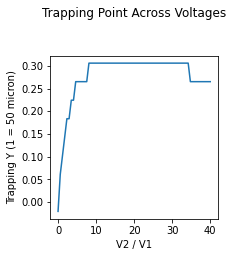

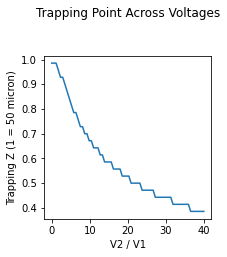

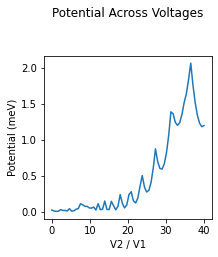

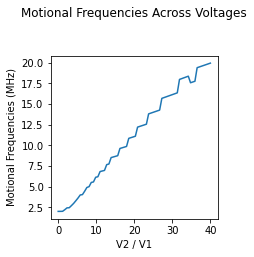

In [18]:
plt.figure(figsize = (3,3))
plt.plot(factors_V2, horiz_y_mins)
plt.xlabel("V2 / V1")
plt.ylabel("Trapping Y (1 = 50 micron)")
plt.title("Trapping Point Across Voltages", y= 1.2)
plt.show()

plt.figure(figsize = (3,3))
plt.plot(factors_V2, horiz_z_mins)
plt.xlabel("V2 / V1")
plt.ylabel("Trapping Z (1 = 50 micron)")
plt.title("Trapping Point Across Voltages", y= 1.2)
plt.show()

plt.figure(figsize = (3,3))
plt.plot(factors_V2, horiz_pots * 1e3)
plt.xlabel("V2 / V1")
plt.ylabel("Potential (meV)")
plt.title("Potential Across Voltages", y= 1.2)
plt.show()

plt.figure(figsize = (3,3))
plt.plot(factors_V2, horiz_freqs)
plt.xlabel("V2 / V1")
plt.ylabel("Motional Frequencies (MHz)")
plt.title("Motional Frequencies Across Voltages", y= 1.2)
plt.show()

